# Getting Unique: Exploring the Impact of Rare Player Combinations in Best Ball Mania

## Participant: Aidan Hall

Twitter: [@tistonionwings](https://twitter.com/tistonionwings)

GitHub: [aidanhall21](https://github.com/aidanhall21)

### Introduction

A strategy I implemented last year when faced with one of my many many late first round draft slots was to purposely select two players with second round ADPs. Instead of drafting **Davante Adams** and **Saquon Barkley** like everyone else I would go with a **D'Andre Swift** and **Mike Evans** pairing. I would get similar production and upside from a combination of players few others would have without giving up an opportunity to draft one of the ultra elite players with a top six overall pick, the thinking went. After all, Week 17 is all that matters and we know from DFS that smartly constructing lineups with lower owned players is key to winning large field tournaments like the Best Ball Mania final round.

I, unfortunately, didn't get a chance to see this strategy come to its practical conclusions since all my teams flamed out before reaching the final round. However, I decided to take a look back and see whether or not I was on to something.

**My submission explores whether drafting relatively unique player combinations through the first four rounds of the draft meaningfully impacts advance rate and/or playoff week win rates and if so what are some strategies we can consider that can lead to more uncommon combos.**

---

### Setup

First I load my packages and combine all BBMIII data into a single dataframe for ease of use:

In [118]:
import os
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import nfl_data_py as nfl
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
pd.set_option('display.max_columns', None)

all_bbm3_data = pd.DataFrame()

# BBMIII regular season fast drafts
path = "data/2022/regular_season/fast/"
for r, d, f in os.walk(path):
    for file in f:
        if 'csv' in file:
            df = pd.read_csv(os.path.join(r, file))
            all_bbm3_data = pd.concat([all_bbm3_data,df])

# BBMIII regular season slow drafts
path = "data/2022/regular_season/mixed/"
for r, d, f in os.walk(path):
    for file in f:
        if 'csv' in file:
            df = pd.read_csv(os.path.join(r, file))
            all_bbm3_data = pd.concat([all_bbm3_data,df])

all_bbm3_data = all_bbm3_data.reset_index(drop=True)
all_bbm3_data.head()

,draft_id,draft_time,clock,draft_entry_id,tournament_entry_id,tournament_round_draft_entry_id,tournament_round_number,player_name,position_name,bye_week,projection_adp,pick_order,overall_pick_number,team_pick_number,pick_points,roster_points,playoff_team
0,bed5abf0-9f8a-4ee5-bcc2-b86c4735afc5,2022-08-15 06:04:54.011858,30,99c03ad3-1162-4c21-8e59-1511393f1548,33e319d9-ac81-48d8-89b8-e66b7dcab3d6,8e53cbab-197f-4728-abbd-a52db326643c,1,Hayden Hurst,TE,10,177.15,2,170,15,60.30,1424.96,0
1,bed5abf0-9f8a-4ee5-bcc2-b86c4735afc5,2022-08-15 06:04:54.011858,30,5486f630-4676-48d6-9343-2b760484ece6,5042797a-c80e-4cf6-b84b-34f98fa3224d,62cae918-a2b6-4ded-9996-37c1f6fc7681,1,Kirk Cousins,QB,7,116.96,3,118,10,161.20,1412.96,0
2,bed5abf0-9f8a-4ee5-bcc2-b86c4735afc5,2022-08-15 06:04:54.011858,30,6305bc02-4e38-4a4d-ae45-4a7496c33226,75d7adc6-2795-4fb3-b9db-2fa4a2e896a1,1b70668e-4783-4869-be3f-8d918a89a4a3,1,Austin Ekeler,RB,8,6.20,5,5,1,237.00,1242.60,0
3,bed5abf0-9f8a-4ee5-bcc2-b86c4735afc5,2022-08-15 06:04:54.011858,30,99c03ad3-1162-4c21-8e59-1511393f1548,33e319d9-ac81-48d8-89b8-e66b7dcab3d6,8e53cbab-197f-4728-abbd-a52db326643c,1,Davis Mills,QB,6,203.75,2,194,17,34.58,1424.96,0
4,bed5abf0-9f8a-4ee5-bcc2-b86c4735afc5,2022-08-15 06:04:54.011858,30,9471a977-fdc2-47a1-bf8c-9ead0d9f8d8e,62948f4c-ac38-4d06-b35a-ba88e4ecd346,6b217ff8-0b10-4e55-a495-466d53c398bc,1,Davante Adams,WR,6,10.82,11,11,1,236.90,1413.98,0


After some slight modifications, I create an ADP Value column that calculates the real-time ADP value for that particular draft pick:

In [119]:
# Fixing two instances where ADP data was incorrect
all_bbm3_data.loc[(all_bbm3_data['draft_id'] == '0d311a9d-05da-4875-a2a9-de548cecb930') & (all_bbm3_data['player_name'] == 'DJ Moore'), 'projection_adp'] = 33.15
all_bbm3_data.loc[(all_bbm3_data['draft_id'] == 'a9d7863e-76f8-4ee5-8b26-58ee04ef3a20') & (all_bbm3_data['player_name'] == "D'Andre Swift"), 'projection_adp'] = 16.07

# Replace FB position with RB for consistency
all_bbm3_data['position_name'] = all_bbm3_data['position_name'].replace('FB', 'RB')

# Create 'adp_value' column
# Treat players drafted without an ADP as having an ADP of 240
all_bbm3_data.loc[all_bbm3_data['projection_adp'] == 0.0, 'projection_adp'] = 240
all_bbm3_data.loc[:, 'adp_value'] = all_bbm3_data['overall_pick_number'].sub(all_bbm3_data['projection_adp'])

# Sorting by player name helps us later when dealing with player combinations
all_bbm3_data = all_bbm3_data.sort_values('player_name').reset_index(drop=True)


My submission makes use of the "estimated wins" methodology that Mike Leone wrote about in his [Best Ball Manifesto](https://establishtherun.com/best-ball-mania-manifesto-a-guide-to-winning-big-on-underdog-fantasy/). By taking all of the playoff teams and treating each week throughout the season as a playoff week we get a much bigger sample of teams/playoff weeks with which to tease out any potential signal in our analysis.

My calculations were the same as his:

>For each team and each week, I determined if their weekly score was high enough to be credited with an “estimated win”. To get credited with an “estimated win” in the quarterfinals, you needed a top 1/10 score; for the semifinals, a top 1/16 score, and for the finals, a top 1/470 score.

The first thing I did was get a list of all playoff team ids:

In [120]:
bbm3_quarterfinals_data = pd.DataFrame()

# BBMIII Quarterfinals data
path = "data/2022/post_season/quarterfinals/"
for r, d, f in os.walk(path):
    for file in f:
        if 'csv' in file:
            df = pd.read_csv(os.path.join(r, file))
            bbm3_quarterfinals_data = pd.concat([bbm3_quarterfinals_data,df])

bbm3_quarterfinals_data = bbm3_quarterfinals_data.reset_index(drop=True)

# Get unique values of 'tournament_entry_id'
advancing_tournament_entry_ids = bbm3_quarterfinals_data['tournament_entry_id'].unique().tolist()


I made use of the [nfl_data_py](https://github.com/cooperdff/nfl_data_py) library for weekly scoring data:

In [ ]:
columns = ['player_id', 'player_display_name', 'recent_team', 'position', 'position_group', 'week', 'passing_yards', 
           'passing_tds', 'interceptions', 'sack_fumbles_lost', 'passing_2pt_conversions', 'rushing_yards', 
           'rushing_tds', 'rushing_fumbles_lost', 'rushing_2pt_conversions', 'receptions', 'receiving_yards',
           'receiving_tds', 'receiving_fumbles_lost', 'receiving_2pt_conversions']

# Import data from the 2022 season
nfl_weekly_data = nfl.import_weekly_data([2022], columns=columns)

# Create a column for points scored using Underdog's scoring system
nfl_weekly_data['fantasy_points'] = (
    0.5 * nfl_weekly_data['receptions'] +
    0.1 * nfl_weekly_data['receiving_yards'] +
    6 * nfl_weekly_data['receiving_tds'] +
    0.1 * nfl_weekly_data['rushing_yards'] +
    6 * nfl_weekly_data['rushing_tds'] +
    2 * nfl_weekly_data['rushing_2pt_conversions'] +
    2 * nfl_weekly_data['passing_2pt_conversions'] +
    2 * nfl_weekly_data['receiving_2pt_conversions'] -
    nfl_weekly_data['interceptions'] -
    2 * nfl_weekly_data['sack_fumbles_lost'] -
    2 * nfl_weekly_data['rushing_fumbles_lost'] -
    2 * nfl_weekly_data['receiving_fumbles_lost'] +
    0.04 * nfl_weekly_data['passing_yards'] +
    4 * nfl_weekly_data['passing_tds']
)

# Fix any naming inconsistencies between the two data sources
nfl_weekly_data_player_name_replacements = {
    'D.J. Moore': 'DJ Moore',
    'Josh Palmer': 'Joshua Palmer',
    'D.J. Chark': 'DJ Chark',
    'A.J. Dillon': 'AJ Dillon',
    'K.J. Hamler': 'KJ Hamler',
    'Jeffery Wilson': 'Jeff Wilson',
    'Robby Anderson': 'Robbie Anderson',
    'Mitchell Trubisky': 'Mitch Trubisky',
    'Jamycal Hasty': 'JaMycal Hasty',
    'Joe Fortson': 'Jordy Fortson',
    'Ty Johnson': 'Tyler Johnson',
    "D'Wayne Eskridge": 'Dee Eskridge',
    'Scott Miller': 'Scotty Miller',
    'Phillip Walker': 'PJ Walker',
    'Joe Fortson': 'Jody Fortson',
    'D.J. Turner': 'DJ Turner',
    'Mike Woods': 'Michael Woods',
    'Ty Johnson': 'Ty Johnson'
}

nfl_weekly_data['player_display_name'].replace(nfl_weekly_data_player_name_replacements, inplace=True)

nfl_weekly_data = nfl_weekly_data.sort_values('week').reset_index(drop=True)

# Filter out non-playoff teams and create a new dataframe
playoff_teams = all_bbm3_data[all_bbm3_data['tournament_entry_id'].isin(advancing_tournament_entry_ids)].reset_index(drop=True)


I then find the scores for each team each week and check if it's enough to earn an estimated win in any of the playoff rounds. Anyone who wants to view the full results can do so here: [BBMIII Estimated Wins](https://docs.google.com/spreadsheets/d/1mq2dFTuY_WYEv-wO98jzGG8lNkSb9NIOitxtIwig-Jw/edit?usp=sharing)

In [ ]:
## NOTE: To anyone trying to reproduce the below code it will likely take at least a few hours to run.

# Create an empty list to store the filtered and merged data for each week
weekly_data = pd.DataFrame()

# Loop through each week
for week in range(1, 18):

    # Filter nfl_weekly_data based on the 'week' column
    nfl_week_data = nfl_weekly_data[nfl_weekly_data['week'] == week]

    # Merge fantasy_points column onto playoff_teams based on player names
    merged_data = pd.merge(nfl_week_data, all_bbm3_data, left_on='player_display_name', right_on='player_name')
    
    # Group by tournament_entry_id and position_group, and find the highest scores for each group
    qb_group = merged_data[merged_data['position_name'] == 'QB'].groupby('tournament_entry_id').apply(lambda x: x.nlargest(1, 'fantasy_points'))
    rb_group = merged_data[merged_data['position_name'] == 'RB'].groupby('tournament_entry_id').apply(lambda x: x.nlargest(2, 'fantasy_points'))
    wr_group = merged_data[merged_data['position_name'] == 'WR'].groupby('tournament_entry_id').apply(lambda x: x.nlargest(3, 'fantasy_points'))
    te_group = merged_data[merged_data['position_name'] == 'TE'].groupby('tournament_entry_id').apply(lambda x: x.nlargest(1, 'fantasy_points'))

    # Filter out the above players to get our pool of FLEX candidates
    filtered_data = merged_data[
        (~merged_data['position_name'].isin(['QB'])) &
        (~merged_data.index.isin(qb_group.index.get_level_values(1))) &
        (~merged_data.index.isin(rb_group.index.get_level_values(1))) &
        (~merged_data.index.isin(wr_group.index.get_level_values(1))) &
        (~merged_data.index.isin(te_group.index.get_level_values(1)))
    ]
    
    flex_group = filtered_data.groupby('tournament_entry_id').apply(lambda x: x.nlargest(1, 'fantasy_points'))
    
    result = pd.concat([qb_group, rb_group, wr_group, te_group, flex_group])
    result['week'] = week
    
    result.reset_index(drop=True, inplace=True)

    # Group the merged dataframe by tournament_entry_id and sum up fantasy points
    grouped_data = result.groupby('tournament_entry_id')['fantasy_points'].sum().reset_index()

    # Add new estimated wins columns
    grouped_data['qf_estimated_win'] = np.where(grouped_data['fantasy_points'] >= np.percentile(grouped_data['fantasy_points'], 90), 1, 0)
    grouped_data['sf_estimated_win'] = np.where(grouped_data['fantasy_points'] >= np.percentile(grouped_data['fantasy_points'], 1500 / 16), 1, 0)
    grouped_data['finals_estimated_win'] = np.where(grouped_data['fantasy_points'] >= np.percentile(grouped_data['fantasy_points'], 46900 / 470), 1, 0)
    grouped_data['week'] = week
    
    # Append the grouped data to the weekly_data list
    weekly_data = pd.concat([weekly_data, grouped_data])
    
# Group the combined data by tournament_entry_id and calculate the average values to get an estimated win percentage
# for each stage of the playoffs
estimated_win_rates_by_playoff_team = weekly_data.groupby('tournament_entry_id').agg({
    'qf_estimated_win': 'mean',
    'sf_estimated_win': 'mean',
    'finals_estimated_win': 'mean'
}).reset_index()


Now I look at each team's picks through the first 2, first 3, and first 4 rounds of the draft and calculate how many other teams have that same combination of players throughout their entire roster. I also break that number into 10th percentile buckets with bucket 1 being the most rare 10 percent of combinations and bucket 10 being the most common 10 percent of combinations. I'm calling these "Dupe Percentile Buckets."

In [10]:
## NOTE: To anyone trying to reproduce the below code it will likely take at least a few hours to run.
## I welcome any suggestions on how to optimize/speed up the process

# Get every entry's full roster
full_roster_list = all_bbm3_data.groupby("tournament_entry_id")["player_name"].agg(list)

# Convert the grouped Series back to a DataFrame
full_roster_list = full_roster_list.reset_index()
full_roster_list = pd.DataFrame(full_roster_list, columns=["tournament_entry_id", "player_name"])

# Initialize an empty dataframe
players_through_x_rounds_df = pd.DataFrame()

# Iterate over the top_picks values
for top_picks in [2, 3, 4]:
    
    # Filter our dataset to only players selected with the top X picks
    filtered_df = all_bbm3_data.loc[all_bbm3_data['team_pick_number'] <= top_picks].reset_index(drop=True)

    # Group the filtered dataframe by 'tournament_entry_id'
    grouped_df = filtered_df.groupby('tournament_entry_id').apply(lambda x: pd.Series({
        f'players_through_{top_picks}': list(x['player_name'])
    })).reset_index()

    # Convert the lists in the 'players_through_{top_picks}' column to tuples to make them hashable
    grouped_df[f'players_through_{top_picks}_tuple'] = grouped_df[f'players_through_{top_picks}'].apply(tuple)

    # Get unique lists of tuples
    unique_lists = grouped_df[f'players_through_{top_picks}_tuple'].unique()

    combo_counter = {}
    
    i = 0

    for combo in unique_lists:
        
        # Create a new column to store the count of occurrences
        full_roster_list['occurrences'] = full_roster_list['rostered_players'].apply(lambda x: all(name in x for name in combo))

        # Count the occurrences
        occurrence_count = full_roster_list['occurrences'].sum()

        key = tuple(combo)
    
        combo_counter[key] = occurrence_count
        
        i = i + 1
        
    combo_df = pd.DataFrame.from_dict(combo_counter, orient='index', columns=[f'duplicate_teams_through_{top_picks}']).reset_index().rename(columns={'index': f'drafted_players_through_{top_picks}'})

    # Merge combo_df onto grouped_df
    grouped_df = pd.merge(grouped_df, combo_df, left_on=f'players_through_{top_picks}_tuple', right_on=f'drafted_players_through_{top_picks}', how='left')

    # If players_through_x_rounds_df is empty, copy grouped_df into it
    # else merge players_through_x_rounds_df and grouped_df on 'tournament_entry_id'
    if players_through_x_rounds_df.empty:
        players_through_x_rounds_df = grouped_df
    else:
        players_through_x_rounds_df = pd.merge(players_through_x_rounds_df, grouped_df, on='tournament_entry_id')
        
# Breakdown 'duplicate_teams_through_{top_picks}' into 10th percentile buckets for ease of analysis
dupe_percentiles_2 = np.percentile(players_through_x_rounds_df['duplicate_teams_through_2'], np.linspace(0, 100, 11)) 
dupe_percentiles_3 = np.percentile(players_through_x_rounds_df['duplicate_teams_through_3'], np.linspace(0, 100, 11)) 
dupe_percentiles_4 = np.percentile(players_through_x_rounds_df['duplicate_teams_through_4'], np.linspace(0, 100, 11)) 

# Assign a value from 1 to 10 based on the percentile
players_through_x_rounds_df['dupe_percentile_bucket_2'] = pd.cut(players_through_x_rounds_df['duplicate_teams_through_2'], dupe_percentiles_2, labels=range(1, 11))
players_through_x_rounds_df['dupe_percentile_bucket_3'] = pd.cut(players_through_x_rounds_df['duplicate_teams_through_3'], dupe_percentiles_3, labels=range(1, 11))
players_through_x_rounds_df['dupe_percentile_bucket_4'] = pd.cut(players_through_x_rounds_df['duplicate_teams_through_4'], dupe_percentiles_4, labels=range(1, 11))

# Find percentage of all teams with the same combination of players through X rounds
players_through_x_rounds_df['full_rosters_combo_pct_2'] = players_through_x_rounds_df['duplicate_teams_through_2'] / 4512
players_through_x_rounds_df['full_rosters_combo_pct_3'] = players_through_x_rounds_df['duplicate_teams_through_3'] / 4512
players_through_x_rounds_df['full_rosters_combo_pct_4'] = players_through_x_rounds_df['duplicate_teams_through_4'] / 4512

players_through_x_rounds_df['dupe_percentile_bucket_2'].fillna(1, inplace=True)
players_through_x_rounds_df['dupe_percentile_bucket_3'].fillna(1, inplace=True)
players_through_x_rounds_df['dupe_percentile_bucket_4'].fillna(1, inplace=True)

players_through_x_rounds_df.head()


,tournament_entry_id,players_through_2,players_through_2_tuple,drafted_players_through_2,duplicate_teams_through_2,players_through_3,players_through_3_tuple,drafted_players_through_3,duplicate_teams_through_3,players_through_4,players_through_4_tuple,drafted_players_through_4,duplicate_teams_through_4,dupe_percentile_bucket_2,dupe_percentile_bucket_3,dupe_percentile_bucket_4,full_rosters_combo_pct_2,full_rosters_combo_pct_3,full_rosters_combo_pct_4
0,0000146a-e245-49c3-8a4e-8e739cfe1e46,"['Javonte Williams', 'Austin Ekeler']","('Javonte Williams', 'Austin Ekeler')","('Javonte Williams', 'Austin Ekeler')",3204,"['Josh Allen', 'Javonte Williams', 'Austin Eke...","('Josh Allen', 'Javonte Williams', 'Austin Eke...","('Josh Allen', 'Javonte Williams', 'Austin Eke...",184,"['Josh Allen', 'Javonte Williams', 'Gabe Davis...","('Josh Allen', 'Javonte Williams', 'Gabe Davis...","('Josh Allen', 'Javonte Williams', 'Gabe Davis...",28,5,4,7,0.710106,0.040780,0.006206
1,0000225d-54fa-4334-aa1e-41e7adaa2542,"['Alvin Kamara', 'Justin Jefferson']","('Alvin Kamara', 'Justin Jefferson')","('Alvin Kamara', 'Justin Jefferson')",2554,"['Alvin Kamara', 'Leonard Fournette', 'Justin ...","('Alvin Kamara', 'Leonard Fournette', 'Justin ...","('Alvin Kamara', 'Leonard Fournette', 'Justin ...",278,"['Alvin Kamara', 'Leonard Fournette', 'Justin ...","('Alvin Kamara', 'Leonard Fournette', 'Justin ...","('Alvin Kamara', 'Leonard Fournette', 'Justin ...",26,3,6,6,0.566046,0.061613,0.005762
2,00003d67-9d4b-47ad-a8a4-d3856480a821,"['CeeDee Lamb', ""Ja'Marr Chase""]","('CeeDee Lamb', ""Ja'Marr Chase"")","('CeeDee Lamb', ""Ja'Marr Chase"")",981,"['Saquon Barkley', 'CeeDee Lamb', ""Ja'Marr Cha...","('Saquon Barkley', 'CeeDee Lamb', ""Ja'Marr Cha...","('Saquon Barkley', 'CeeDee Lamb', ""Ja'Marr Cha...",10,"['Saquon Barkley', 'CeeDee Lamb', 'Michael Pit...","('Saquon Barkley', 'CeeDee Lamb', 'Michael Pit...","('Saquon Barkley', 'CeeDee Lamb', 'Michael Pit...",1,1,1,1,0.217420,0.002216,0.000222
3,00004939-5e99-4dfb-b597-d6463eacf6aa,"['Mark Andrews', 'Christian McCaffrey']","('Mark Andrews', 'Christian McCaffrey')","('Mark Andrews', 'Christian McCaffrey')",5022,"['Mark Andrews', 'Josh Allen', 'Christian McCa...","('Mark Andrews', 'Josh Allen', 'Christian McCa...","('Mark Andrews', 'Josh Allen', 'Christian McCa...",141,"['Mark Andrews', 'Josh Allen', 'Christian McCa...","('Mark Andrews', 'Josh Allen', 'Christian McCa...","('Mark Andrews', 'Josh Allen', 'Christian McCa...",17,9,3,5,1.113032,0.031250,0.003768
4,0000766d-7308-495e-ad86-6ddb69dbc3ab,"[""D'Andre Swift"", 'Stefon Diggs']","(""D'Andre Swift"", 'Stefon Diggs')","(""D'Andre Swift"", 'Stefon Diggs')",4434,"['Mike Williams', ""D'Andre Swift"", 'Stefon Dig...","('Mike Williams', ""D'Andre Swift"", 'Stefon Dig...","('Mike Williams', ""D'Andre Swift"", 'Stefon Dig...",423,"['Mike Williams', ""D'Andre Swift"", 'Stefon Dig...","('Mike Williams', ""D'Andre Swift"", 'Stefon Dig...","('Mike Williams', ""D'Andre Swift"", 'Stefon Dig...",46,7,8,8,0.982713,0.093750,0.010195


### Modeling A Well Drafted Team

In order for my eventual conclusions to have any veracity I needed a way to filter out "bad" teams so that they wouldn't skew the data. Whether a drafter is purposely drafting poorly, unaware of basic Best Ball principles like ADP value and roster construction, or just a casual fan picking players they want to root for, I didn't want these teams muddying my anlalysis. Remember, the focus of this submission is to determine the degree, if any, to which drafters should be intentionally eschewing ADP rankings in order to start their drafts in a relatively unique way.

I decided to train a simple model designed to rank teams by predicted regular season advance rate based on a collection of metrics generally accepted by the Best Ball industry to be good indicators of a successful draft.

Those metrics are:

* Draft Capital allocated to each position (I downloaded Mike Leone's Draft Capital values from [this sheet](https://docs.google.com/spreadsheets/d/1sLBV5Arsu6m7ilSwvRzxjRWaImjl06yBA2aSPkDycBI/edit#gid=0))
* Aggregate Real Time ADP value for each position as well as through the early, mid, and late rounds of the draft
* Number of Players Stacked with your quarterback

The purpose of the model is not to be precise in our ordering of teams, but to get a sense of which teams were "well drafted."

In [121]:
# Determine draft capital spent on each position
# From this link (https://docs.google.com/spreadsheets/d/1sLBV5Arsu6m7ilSwvRzxjRWaImjl06yBA2aSPkDycBI/edit#gid=0)
draft_capital_values = pd.read_csv('draft_capital_values.csv')
all_bbm3_data = pd.merge(all_bbm3_data, draft_capital_values, on='overall_pick_number')
draft_capital_grouped = all_bbm3_data.groupby(['tournament_entry_id', 'position_name'])['draft_capital_adj'].sum().reset_index()
draft_capital_pivot = pd.pivot_table(draft_capital_grouped, values='draft_capital_adj', index='tournament_entry_id', columns='position_name', fill_value=0)
draft_capital_pivot.reset_index(inplace=True)
draft_capital_pivot.columns = ['tournament_entry_id', 'QB_draft_capital', 'RB_draft_capital', 'TE_draft_capital', 'WR_draft_capital']

# Determine real time ADP value for each position in each individual draft
real_time_adp_value_position_grouped = all_bbm3_data.groupby(['tournament_entry_id', 'position_name'])['adp_value'].sum().reset_index()
adp_pivot = pd.pivot_table(real_time_adp_value_position_grouped, values='adp_value', index='tournament_entry_id', columns='position_name', fill_value=0)
adp_pivot.reset_index(inplace=True)
adp_pivot.columns = ['tournament_entry_id', 'QB_adp_value', 'RB_adp_value', 'TE_adp_value', 'WR_adp_value']

# Determine real time ADP value for each drafter through rounds 2/3/4/5/6 and rounds 7-12 and 13-18
relevant_rounds = [2, 3, 4, 5, 6]
all_real_time_adp_value_round_grouped_dfs = []
for r in relevant_rounds:
    data_slice = all_bbm3_data.loc[all_bbm3_data['team_pick_number'] <= r].reset_index(drop=True)
    real_time_adp_value_round_grouped = data_slice.groupby(['tournament_entry_id'])['adp_value'].sum().reset_index()
    col_name = 'adp_value_through_' + str(r)
    real_time_adp_value_round_grouped = real_time_adp_value_round_grouped.rename(columns={'adp_value': col_name})
    all_real_time_adp_value_round_grouped_dfs.append(real_time_adp_value_round_grouped)
    
data_slice_7_12 = all_bbm3_data.loc[(all_bbm3_data['team_pick_number'] <= 12) & (all_bbm3_data['team_pick_number'] >= 7)].reset_index(drop=True)
data_slice_13_18 = all_bbm3_data.loc[(all_bbm3_data['team_pick_number'] <= 18) & (all_bbm3_data['team_pick_number'] >= 13)].reset_index(drop=True)

real_time_adp_value_7_12 = data_slice_7_12.groupby(['tournament_entry_id'])['adp_value'].sum().reset_index()
real_time_adp_value_13_18 = data_slice_13_18.groupby(['tournament_entry_id'])['adp_value'].sum().reset_index()

real_time_adp_value_7_12 = real_time_adp_value_7_12.rename(columns={'adp_value': 'adp_value_through_7-12'})
real_time_adp_value_13_18 = real_time_adp_value_13_18.rename(columns={'adp_value': 'adp_value_through_13-18'})

all_real_time_adp_value_round_grouped_dfs.append(real_time_adp_value_7_12)
all_real_time_adp_value_round_grouped_dfs.append(real_time_adp_value_13_18)

# Start by merging the first two dataframes
merged_real_time_adp_value_round_df = pd.merge(all_real_time_adp_value_round_grouped_dfs[0], all_real_time_adp_value_round_grouped_dfs[1], on="tournament_entry_id", how="outer")

# Merge the rest of the dataframes
for df in all_real_time_adp_value_round_grouped_dfs[2:]:
    merged_real_time_adp_value_round_df = pd.merge(merged_real_time_adp_value_round_df, df, on="tournament_entry_id", how="outer")

# Use the previously acquired weekly scoring data to get a list of players and teams
nfl_weekly_data = nfl_weekly_data.drop_duplicates(subset='player_display_name', keep='first')
player_teams = nfl_weekly_data[['player_display_name', 'recent_team']]

data_with_teams = pd.merge(all_bbm3_data, player_teams, left_on='player_name', right_on='player_display_name')
data_with_teams = data_with_teams.sort_values('tournament_entry_id').reset_index(drop=True)

# Define a function that will count stacked players with a team's quarterbacks
def process_group(group):
    # Get the recent_team values for rows where position_name is 'QB'
    qb_teams = group[group['position_name'] == 'QB']['recent_team'].unique()

    # Define the different position groups we're interested in
    position_groups = {
        'TE': ['TE'],
        'RB': ['RB'],
        'WR': ['WR'],
        'TE_WR_RB': ['TE', 'WR', 'RB'],
        'TE_WR': ['TE', 'WR']
    }

    # Calculate the counts for each position group
    result = {}
    for group_name, positions in position_groups.items():
        result[group_name] = len(group[(group['position_name'].isin(positions)) & (group['recent_team'].isin(qb_teams))])

    # Return the result as a Series
    return pd.Series(result)

# Group by tournament_entry_id and apply the function to each group
stacks_result_df = data_with_teams.groupby('tournament_entry_id').apply(process_group)

# Reset the index and rename the columns
stacks_result_df = stacks_result_df.reset_index().rename(columns={'index': 'tournament_entry_id'})
stacks_result_df = stacks_result_df.rename(columns={
    'TE': 'Stacked_TE',
    'RB': 'Stacked_RB',
    'WR': 'Stacked_WR',
    'TE_WR_RB': 'Stacked_Players',
    'TE_WR': 'Stacked_Pass_Catchers'
    })

# Merge each dataframe on 'tournament_entry_id'
model_df = pd.merge(draft_capital_pivot, adp_pivot, on='tournament_entry_id', how='outer')
model_df = pd.merge(model_df, merged_real_time_adp_value_round_df, on='tournament_entry_id', how='outer')
model_df = pd.merge(model_df, stacks_result_df, on='tournament_entry_id', how='outer')
model_df['advanced'] = model_df['tournament_entry_id'].apply(lambda x: 1 if x in advancing_tournament_entry_ids else 0)

model_df.head()


,tournament_entry_id,QB_draft_capital,RB_draft_capital,TE_draft_capital,WR_draft_capital,QB_adp_value,RB_adp_value,TE_adp_value,WR_adp_value,adp_value_through_2,adp_value_through_3,adp_value_through_4,adp_value_through_5,adp_value_through_6,adp_value_through_7-12,adp_value_through_13-18,Stacked_TE,Stacked_RB,Stacked_WR,Stacked_Players,Stacked_Pass_Catchers,advanced
0,0000146a-e245-49c3-8a4e-8e739cfe1e46,106,343,67,270,-6.80,-90.63,-0.38,-15.66,-1.48,-3.09,-1.00,4.19,-0.73,-29.63,-83.11,0,1,2,3,2,0
1,0000225d-54fa-4334-aa1e-41e7adaa2542,99,255,40,394,-0.12,2.65,8.03,8.39,0.00,3.90,5.80,6.29,12.13,4.27,2.55,2,1,3,6,5,1
2,00003d67-9d4b-47ad-a8a4-d3856480a821,44,245,25,475,2.11,-15.45,7.51,-0.55,1.18,3.72,0.98,6.11,9.59,-13.63,-2.34,0,0,1,1,1,0
3,00004939-5e99-4dfb-b597-d6463eacf6aa,114,242,132,300,-78.19,-8.32,9.71,36.24,1.55,-3.80,-1.26,-3.94,-0.03,-12.27,-28.26,0,1,0,1,0,1
4,0000766d-7308-495e-ad86-6ddb69dbc3ab,56,331,21,376,-0.42,15.45,0.28,36.81,0.11,4.17,0.09,9.74,17.92,-0.48,34.68,0,0,0,0,0,0


I trained an [XGBoost](https://github.com/dmlc/xgboost) Classifier model that takes in all variables defined in model_df and spits out a prediction which we can interpret as how likely a drafted team is to advance to the playoffs. I define "well drafted" teams as any in which the predicted probability of advancement is greater than 16.7% i.e. greater than the random chance of any team advancing (2 in 12).

I end up with a sample of 197,295 teams with a combined true advance rate of 25.8%. These are the teams for which the rest of the analysis is based off of unless otherwise noted.

In [122]:
# Model training and predictions
X = model_df.drop(['advanced', 'tournament_entry_id'], axis=1)  # features
y = model_df['advanced']  # target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBClassifier(objective='binary:logistic')
model.fit(X_train, y_train)

model_df['pred_adv_prob'] = model.predict_proba(X)[:, 1]

# Merge and prepare dataframe
dupe_bucket_df = players_through_x_rounds_df[['tournament_entry_id', 'dupe_percentile_bucket_2', 'dupe_percentile_bucket_3', 'dupe_percentile_bucket_4']]
model_df = pd.merge(model_df, dupe_bucket_df, on='tournament_entry_id', how='outer')

selected_teams = model_df.loc[model_df['pred_adv_prob'] > (1 / 6)].reset_index(drop=True)
selected_teams = selected_teams[['tournament_entry_id', 'adp_value_through_2', 'adp_value_through_3', 'adp_value_through_4', 'dupe_percentile_bucket_2', 'dupe_percentile_bucket_3', 'dupe_percentile_bucket_4', 'advanced']]


### Where Do Unique Teams Come From?

At this point, before moving on, it would probably be useful to familiarize ourselves with some general characteristics of each bucket, as well as what a more rare or more common combination of players looks like. A smattering of examples is below.

**Through 2 Rounds**:

* Bucket 1: (Draft Slot 10) **D'Andre Swift** / **Mike Evans** (-6.96 real-time ADP value) (474 other teams with same combo)
* Bucket 4: (7) **Davante Adams** / **Saquon Barkley** (0.02) (3,031)
* Bucket 7: (2) **Christian McCaffrey** / **Nick Chubb** (-2.23) (4,369)
* Bucket 10: (4) **Jonathan Taylor** / **A.J. Brown** (0.36) (8,723)

**Through 3 Rounds**:

* Bucket 1: (9) **Joe Mixon** / **Davante Adams** / **Tee Higgins** (4.71) (39)
* Bucket 4: (5) **Cooper Kupp** / **A.J. Brown** / **Mike Williams** (-6.72) (180)
* Bucket 7: (1) **Justin Jefferson** / **Leonard Fournette** / **Deebo Samuel** (2.87) (325)
* Bucket 10: (11) **CeeDee Lamb** / **Davante Adams** / **Travis Etienne** (1.63) (1,175)

**Through 4 Rounds**:

* Bucket 1: (3) **Justin Jefferson** / **A.J. Brown** / **DJ Moore** / **Justin Herbert** (-5.55) (4)
* Bucket 4: (6) **Austin Ekeler** / **Aaron Jones** / **Breece Hall** / **DJ Moore** (-.21) (16)
* Bucket 7: (8) **Austin Ekeler** / **Keenan Allen** / **Deebo Samuel** / **Diontae Johnson** (11) (33)
* Bucket 10: (12) **Stefon Diggs** / **D'Andre Swift** / **Gabe Davis** / **Josh Allen** (-2.39) (221)

---

Now, I wanted to see if there was any correlation between potential uniqueness of a stack and what month that team was drafted in as well as any patterns in whether the overall stack saw positive or negative real-time ADP value.

In [ ]:
# Add a month drafted column to the data
all_bbm3_data['draft_time'] = pd.to_datetime(all_bbm3_data['draft_time'])
all_bbm3_data['month_drafted'] = all_bbm3_data['draft_time'].dt.month

month_drafted = all_bbm3_data[['tournament_entry_id', 'month_drafted']].drop_duplicates(subset='tournament_entry_id', keep='first').reset_index(drop=True)
selected_teams = pd.merge(selected_teams, month_drafted, on='tournament_entry_id', how='inner')


The following figures show what proportion of each Dupe Percentile Bucket was drafted in each month compared to the proportion of overall teams drafted in that month. If a bar is above the dotted line that means that there were more teams that fall into that bucket drafted in that month then we would have expected.

Additionally, the ratio of green to red for each bar corresponds to the ratio of drafts in that bucket-month pairing that had positive real-time ADP value to negative real-time ADP value.

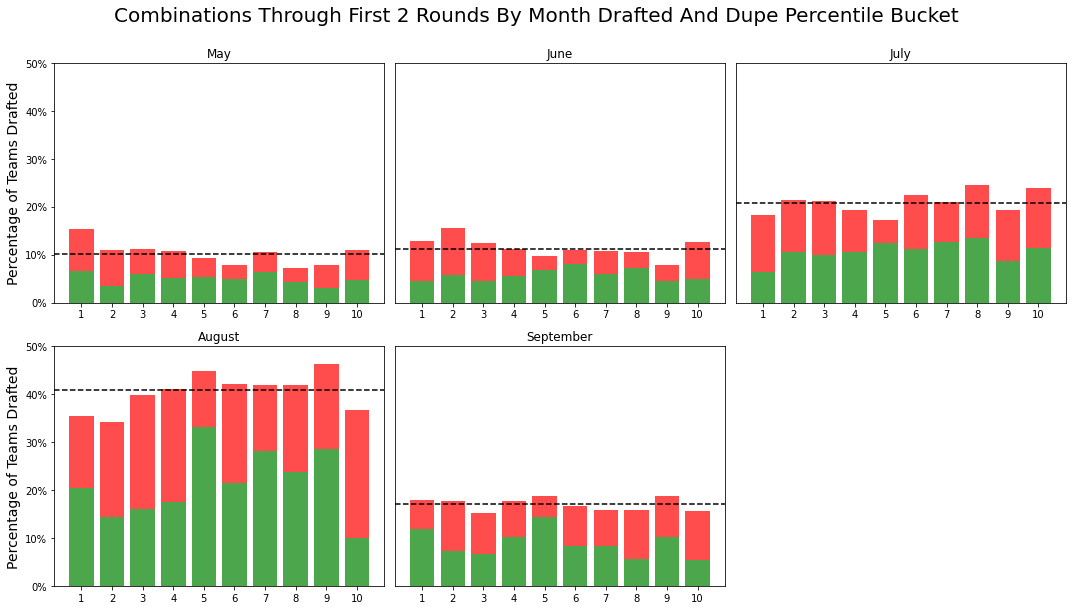

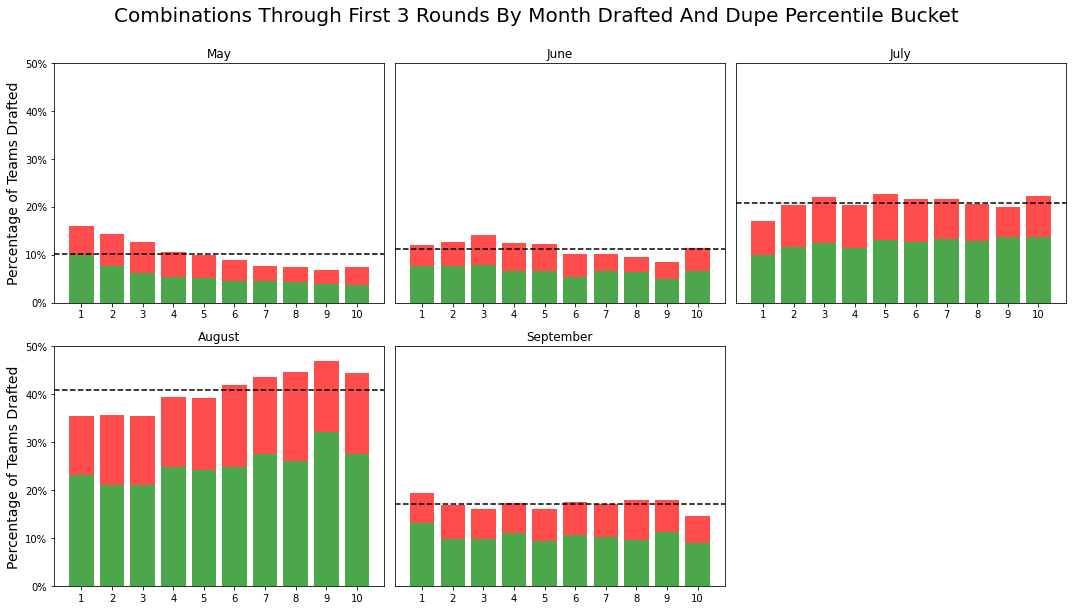

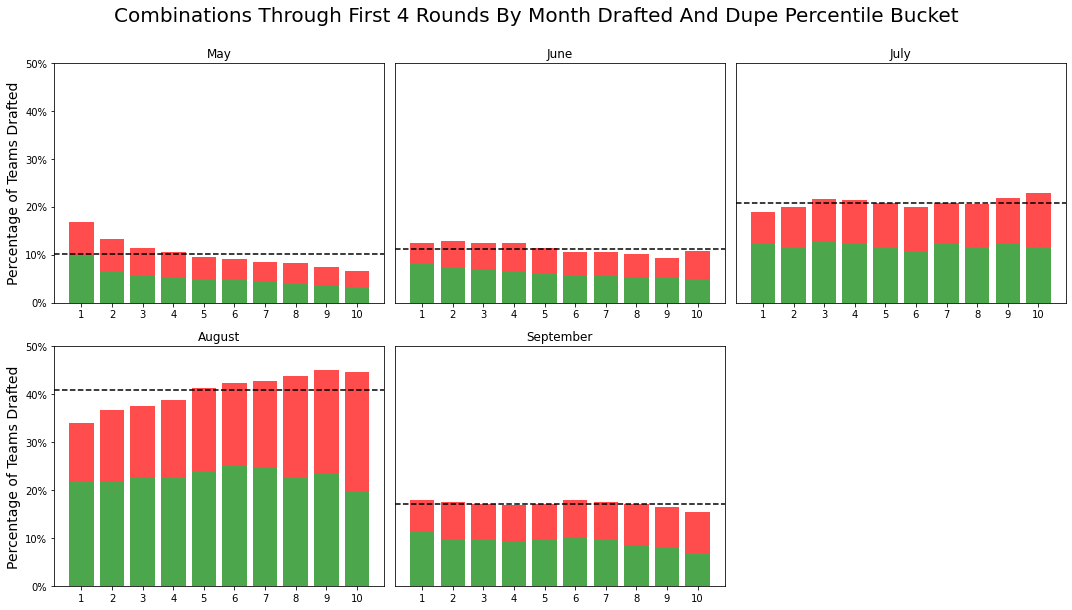

In [304]:
def plot_by_dupe_percentile_bucket(df, bucket):
    selected_teams_by_month = df.sort_values('month_drafted').reset_index(drop=True)
    months = selected_teams_by_month['month_drafted'].unique()

    month_names = {5: 'May', 6: 'June', 7: 'July', 8: 'August', 9: 'September'}

    # calculate the total percentage for each month
    total_percent = selected_teams_by_month['month_drafted'].value_counts(normalize=True) * 100

    fig, axs = plt.subplots(5, 3, figsize=(15, 20))
    axs = axs.flatten()
    fig.suptitle(f'Combinations Through First {bucket} Rounds By Month Drafted And Dupe Percentile Bucket', fontsize=20, y=1)  # Change as needed
    formatter = FuncFormatter(lambda y, _: '{:.0%}'.format(y / 100))

    # calculate the total value counts for each dupe_percentile_bucket value
    total_value_counts = selected_teams_by_month[f'dupe_percentile_bucket_{bucket}'].value_counts()

    for i, month in enumerate(months):
        subset = selected_teams_by_month[selected_teams_by_month['month_drafted'] == month]

        positive_adp = subset[subset[f'adp_value_through_{bucket}'] > 0]
        negative_adp = subset[subset[f'adp_value_through_{bucket}'] <= 0]

        positive_value_counts = (positive_adp[f'dupe_percentile_bucket_{bucket}'].value_counts() / total_value_counts).sort_index() * 100
        negative_value_counts = (negative_adp[f'dupe_percentile_bucket_{bucket}'].value_counts() / total_value_counts).sort_index() * 100

        axs[i].bar(positive_value_counts.index, positive_value_counts.values, color='green', alpha=0.7)
        axs[i].bar(negative_value_counts.index, negative_value_counts.values, bottom=positive_value_counts.values, color='red', alpha=0.7)

        axs[i].set_xticks(np.arange(1, 11))
        axs[i].set_ylim([0, 50])

        if i == 0 or i == 3: 
            axs[i].set_ylabel('Percentage of Teams Drafted', fontsize=14)
            axs[i].yaxis.set_major_formatter(formatter)
        else:
            axs[i].set_yticks([])

        axs[i].set_title(f'{month_names[month]}')

        # add a horizontal line that corresponds to the total percentage of the current month
        axs[i].axhline(y=total_percent[month], color='black', linestyle='--')

    # Remove unused subplots
    for j in range(i + 1, 15):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

# Call the function for dupe_percentile_bucket values 2, 3, and 4
for bucket in range(2, 5):
    plot_by_dupe_percentile_bucket(selected_teams, bucket)


You'll notice that, generally, more unique combinations are more likely to have been drafted either earlier in the year, or very close to the beginning of the season. This could be partly due to ADP being much more inefficient at the very beginning of the drafting window, allowing access to players at the top of the draft board at a value that you otherwise are unlikely to see as we move closer to the season, as well as more casual drafters hopping in drafts in September and making mistakes right out of the gate.

It is also much more likely, especially through rounds 3 and 4, that a team with a rare combination of players got positive real-time ADP value on those players. Turns out a good way to get unique is to take advantage when your fellow drafters gift you a nice value at the top of your draft. This also means, conversely, that reaching for a player in the first 2-4 rounds makes it more likely other sharp drafters in your room can hoard premier players at a value.

---

### Uniqueness By Draft Slot

Knowing from which draft slot drafters are more likely to start with an uncommon group of players could be beneficial in that when we draw those draft slots we can potentially plan whether we want to execute an exploitative strategy before the draft even begins.

In [229]:
# Add a draft slot column to the data
draft_slot_df = all_bbm3_data.loc[all_bbm3_data['team_pick_number'] == 1].reset_index(drop=True)
draft_slot_df = draft_slot_df[['tournament_entry_id', 'overall_pick_number']]
selected_teams = pd.merge(selected_teams, draft_slot_df, on='tournament_entry_id', how='inner')


The first row of graphs below show from which draft slot the most unique 20% (Dupe Percentile Buckets 1 and 2) of teams over the first 2, 3, and 4 round are drafted from. The second row shows results for the least unique 20% (Buckets 9 and 10).

Similar to the graphs from earlier, the ratio of green to red for each bar corresponds to the ratio of drafts that had positive real-time ADP value to negative real-time ADP value. The dashed line corresponds to what we would expect the percentages to be given a uniform random distribution (1 in 12)

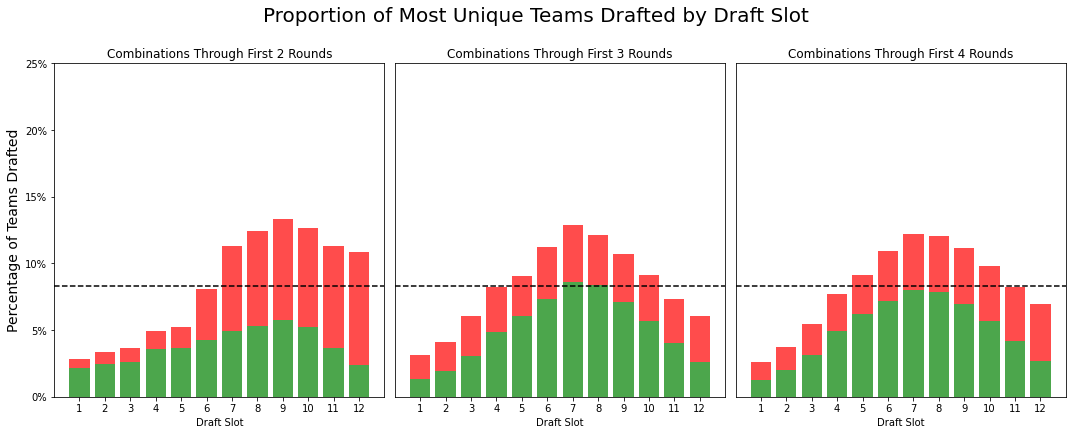

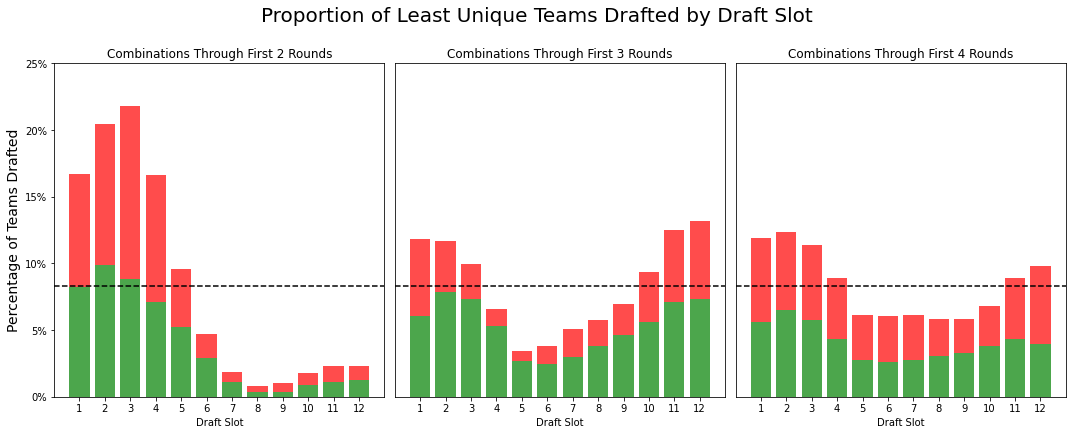

In [314]:
def plot_subset(df, condition):
    fig, axs = plt.subplots(1, 3, figsize=(15, 6))
    axs = axs.flatten()
    if condition == 0: fig.suptitle('Proportion of Most Unique Teams Drafted by Draft Slot', fontsize=20, y=1)
    else: subset = fig.suptitle('Proportion of Least Unique Teams Drafted by Draft Slot', fontsize=20, y=1)

    formatter = FuncFormatter(lambda y, _: '{:.0%}'.format(y/100))

    for i in range(3):
        if condition == 0: subset = df[df[f'dupe_percentile_bucket_{i + 2}'] < 3]
        else: subset = df[df[f'dupe_percentile_bucket_{i + 2}'] > 8]

        positive_adp = subset[subset[f'adp_value_through_{i + 2}'] > 0]
        negative_adp = subset[subset[f'adp_value_through_{i + 2}'] <= 0]

        positive_value_counts = (positive_adp['overall_pick_number'].value_counts() / len(subset)).sort_index() * 100
        negative_value_counts = (negative_adp['overall_pick_number'].value_counts() / len(subset)).sort_index() * 100

        axs[i].bar(positive_value_counts.index, positive_value_counts.values, color='green', alpha=0.7)
        axs[i].bar(negative_value_counts.index, negative_value_counts.values, bottom=positive_value_counts.values, color='red', alpha=0.7)

        axs[i].set_xticks(np.arange(1, 13))
        axs[i].set_ylim([0, 25])
        if i == 0: 
            axs[i].set_ylabel('Percentage of Teams Drafted', fontsize=14)
            axs[i].yaxis.set_major_formatter(formatter)
        else:
            axs[i].set_yticks([])
        axs[i].set_xlabel('Draft Slot')
        axs[i].set_title(f'Combinations Through First {i + 2} Rounds')

        axs[i].axhline(y=(100 / 12), color='black', linestyle='--')

    plt.tight_layout()
    plt.show()

# Call the function
for condition in [0, 1]:
    plot_subset(selected_teams, condition)


Many more of the most unique draft starts begin from a mid to late first round draft slot. More often than not, it appears, those teams are reaching for players with their first two selections before taking advantage of ADP value with their next two picks. Unique teams drafted from early in the first round generally take advantage of second round players the rest of the room passes on and pushes down to them, before reaching for someone with their third pick at the turn.

Teams that begin with the most common combinations of players tend to come from drafting at or near the turns. An explanation for this could be an unwillingness by most drafters to scroll too far down for a player even though, with ~20 other selections in between your next set of picks, it's unlikely those players ever get back to you.

---

### How Does A Unique Start Affect Advance Rates?

The graphics below show the percent change in overall advance rate for each percentile bucket from the overall advance rate for the the entire sample of teams (25.8%). For example, teams that fell into Dupe Percentile Bucket 5 after the first 2 rounds ultimately saw a 15% decrease in their advance rate (~22%) from our expected number.

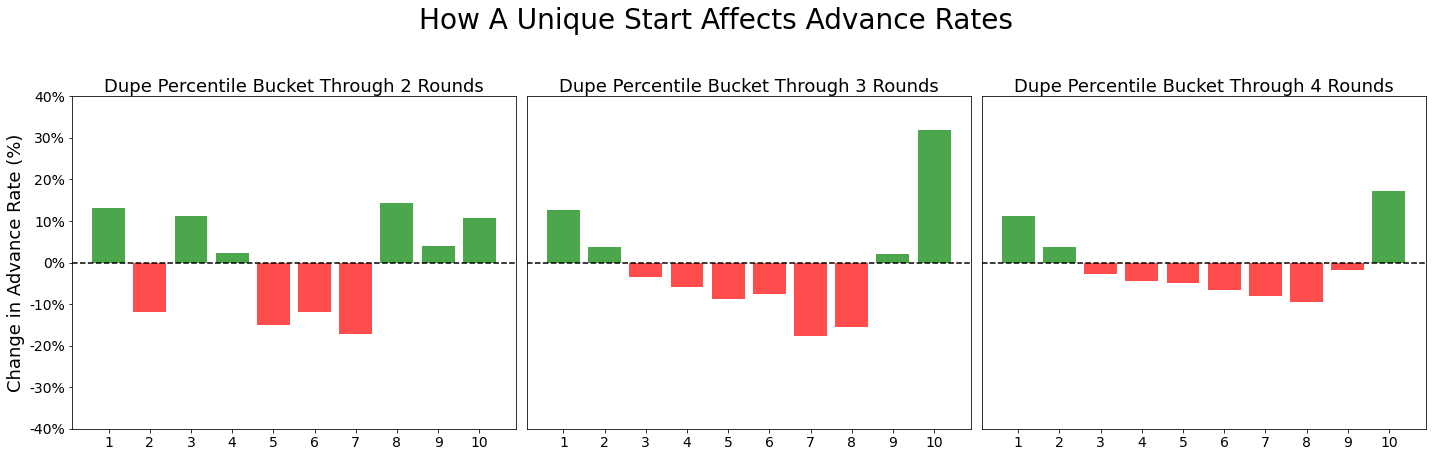

In [331]:
buckets = ['dupe_percentile_bucket_2', 'dupe_percentile_bucket_3', 'dupe_percentile_bucket_4']
formatter = FuncFormatter(lambda y, _: '{:.0%}'.format(y/100))

overall_advance_rate_selected_teams = (selected_teams['advanced'].mean()) * 100

fig, axs = plt.subplots(1, 3, figsize=(20,6))
fig.suptitle('How A Unique Start Affects Advance Rates', fontsize=28, y=1.05)

for i, bucket in enumerate(buckets):
    selected_grouped_df = selected_teams.groupby(bucket)['advanced'].mean().reset_index()
    selected_grouped_df['advanced'] = selected_grouped_df['advanced'] * 100
    advanced_ratio = ((selected_grouped_df['advanced'] / overall_advance_rate_selected_teams) - 1) * 100
    bar_colors = ['green' if x >= 0 else 'red' for x in advanced_ratio.values]
    
    axs[i].bar(selected_grouped_df[bucket], advanced_ratio, color=bar_colors, alpha=0.7)
    axs[i].xaxis.set_label_position('top')
    axs[i].set_xlabel(f'Dupe Percentile Bucket Through {i+2} Rounds', fontsize=18)
    axs[i].set_xticks(range(1, 11))
    axs[i].axhline(y=0, color='black', linestyle='--')
    axs[i].yaxis.set_major_formatter(formatter)
    axs[i].tick_params(axis='both', which='major', labelsize=14)

    if i == 0:
        axs[i].set_ylabel('Change in Advance Rate (%)', fontsize=18)
    else:
        axs[i].set_yticks([])

    axs[i].set_ylim(-40, 40)

plt.tight_layout()
plt.show()


I was somewhat surprised to see the "U" shape in each of the above graphs. It appears, without breaking it down further, that the most unique AND most common starts to drafts can benefit from boosted advance rates.

---

### Breaking It Down Further

Not all unique teams are created equal. Some can be purposely engineered by reaching for one or more players in an attempt to stack players whose ADPs otherwise wouldn't naturally align, and others can take advantage when a player falls to a pick they rarely get to.

The following graphic shows the percent change in advance rate for teams within the same Dupe Percentile Bucket that saw negative real-time ADP value vs. those that saw positive real-time ADP value. A red bar below the line at 0% indicates that teams with negative real-time ADP value within that bucket had worse advance rates than teams with positive real-time ADP value within that bucket.

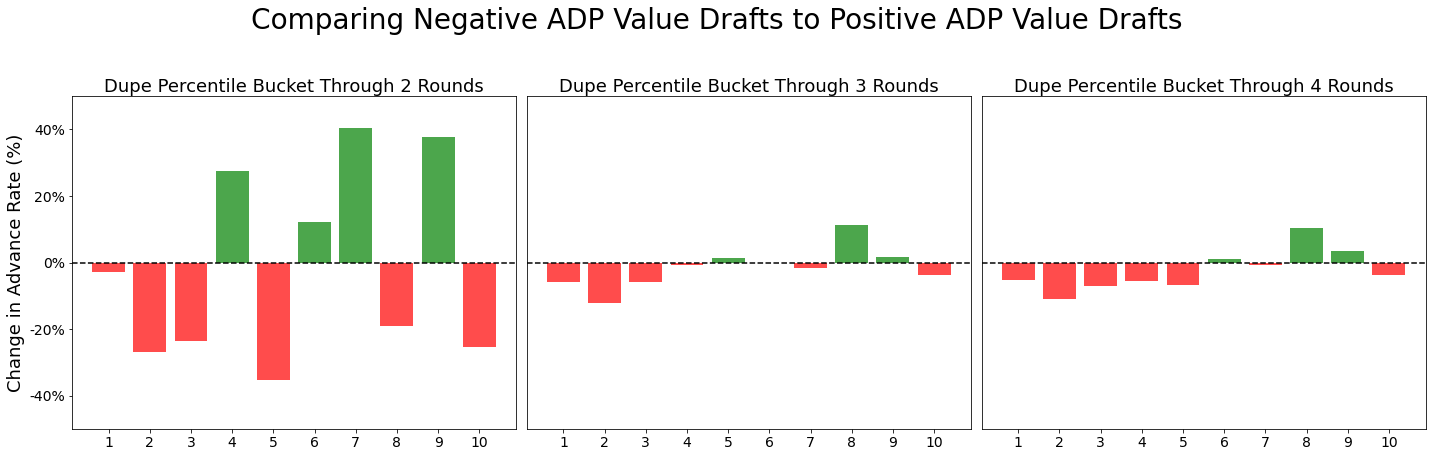

In [332]:
buckets = ['dupe_percentile_bucket_2', 'dupe_percentile_bucket_3', 'dupe_percentile_bucket_4']
formatter = FuncFormatter(lambda y, _: '{:.0%}'.format(y / 100))

fig, axs = plt.subplots(1, 3, figsize=(20,6))
fig.suptitle('Comparing Negative ADP Value Drafts to Positive ADP Value Drafts', fontsize=28, y=1.05)

for i, bucket in enumerate(buckets):
    selected_teams_neg_adp_val = selected_teams.loc[selected_teams[f'adp_value_through_{i+2}'] < 0].reset_index(drop=True)
    selected_teams_pos_adp_val = selected_teams.loc[selected_teams[f'adp_value_through_{i+2}'] >= 0].reset_index(drop=True)

    selected_grouped_neg_adp_val = selected_teams_neg_adp_val.groupby(bucket)['advanced'].mean().reset_index()
    selected_grouped_pos_adp_val = selected_teams_pos_adp_val.groupby(bucket)['advanced'].mean().reset_index()

    advanced_ratio = ((selected_grouped_neg_adp_val['advanced'] / selected_grouped_pos_adp_val['advanced']) - 1) * 100
    bar_colors = ['green' if x >= 0 else 'red' for x in advanced_ratio.values]

    axs[i].bar(advanced_ratio.index + 1, advanced_ratio.values, color=bar_colors, alpha=0.7)
    axs[i].xaxis.set_label_position('top')
    axs[i].set_xlabel(f'Dupe Percentile Bucket Through {i+2} Rounds', fontsize=18)
    axs[i].set_xticks(range(1, 11))
    axs[i].axhline(y=0, color='black', linestyle='--')
    axs[i].yaxis.set_major_formatter(formatter)
    axs[i].tick_params(axis='both', which='major', labelsize=14)

    if i == 0:
        axs[i].set_ylabel('Change in Advance Rate (%)', fontsize=18)
    else:
        axs[i].set_yticks([])

    axs[i].set_ylim(-50, 50)

plt.tight_layout()
plt.show()


Among the teams with the most unique starts to their draft, teams that saw positive real-time ADP value outperformed those with negative real-time ADP value, although remember that teams with negative real-time ADP value in bucket 1 through rounds 2, 3, and 4 still outperformed the overall sample of teams in terms of advance rate.

For the most part teams with positive real-time ADP value outperformed their counterparts within the same bucket or came close enough that any difference can be explained by random variance.

---

### Let's Look At Playoff Win Rates

I'm combining the estimated wins data from earlier with each team's real-time ADP value through rounds 2, 3, and 4, as well as which Dupe Percentile Bucket they fall into in those rounds as well.

In [ ]:
adp_value_2_3_4 = merged_real_time_adp_value_round_df[['tournament_entry_id', 'adp_value_through_2', 'adp_value_through_3', 'adp_value_through_4']]
estimated_win_rates_by_playoff_team = pd.merge(estimated_win_rates_by_playoff_team, dupe_bucket_df, on='tournament_entry_id', how='inner')
estimated_win_rates_by_playoff_team = pd.merge(estimated_win_rates_by_playoff_team, adp_value_2_3_4, on='tournament_entry_id', how='inner')


The figure below shows win rate over expected throughout each of the three playoff rounds by Dupe Percentile Bucket through draft rounds 2, 3, and 4. Remember that the expected win rate for the Quarter finals is 10%, for the Semi Finals is 6.25%, and for the Finals is .213%. Note the change in scale for the third row of graphs.

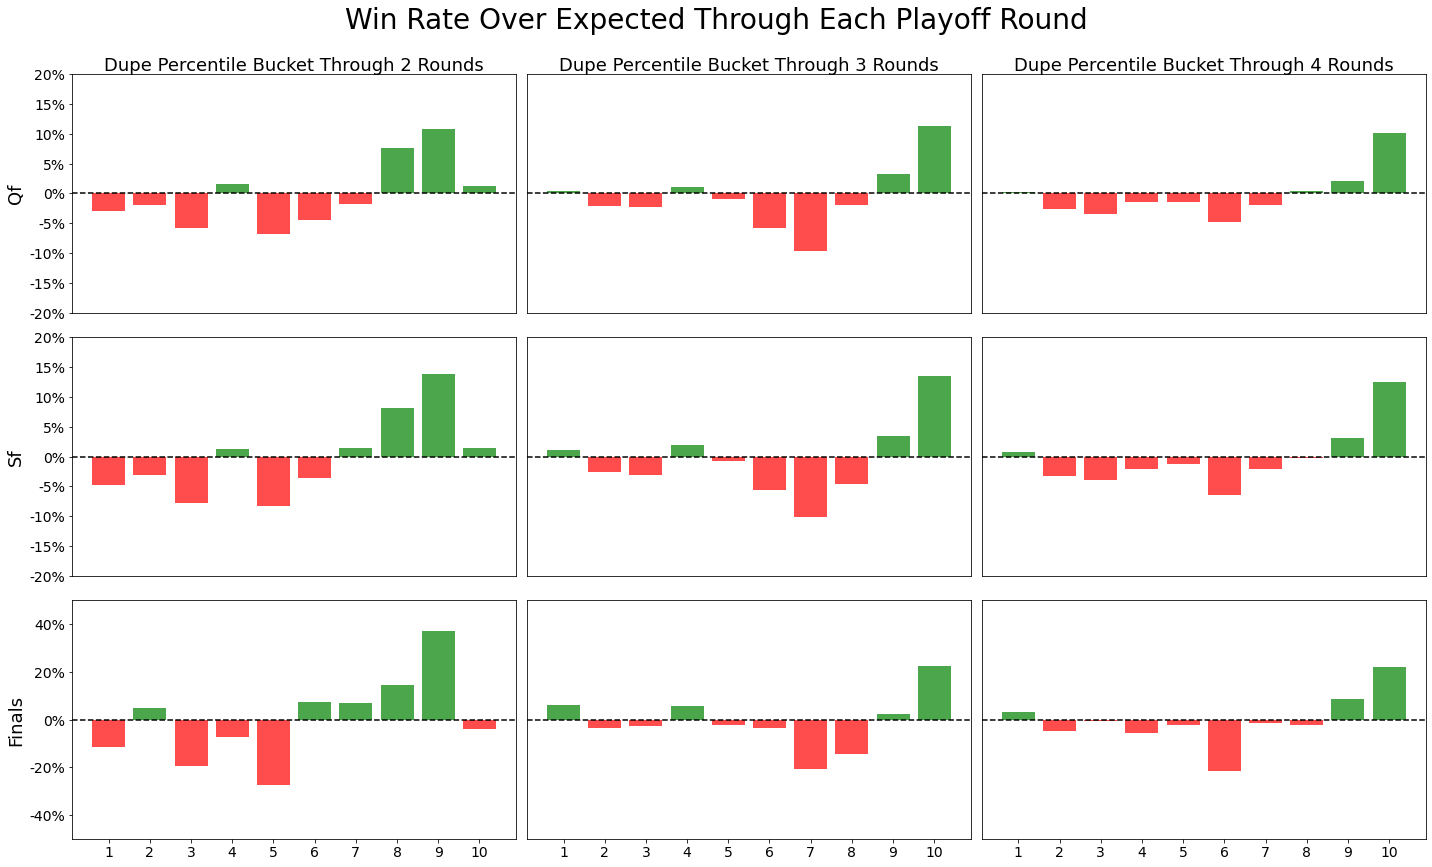

In [334]:
buckets = ['dupe_percentile_bucket_2', 'dupe_percentile_bucket_3', 'dupe_percentile_bucket_4']
rounds = ['qf', 'sf', 'finals']
random_win_rate = {'qf': (1 / 10) * 100, 'sf': (1 / 16) * 100, 'finals': (1 / 470) * 100}

formatter = FuncFormatter(lambda y, _: '{:.0%}'.format(y/100))
fig, axs = plt.subplots(3, 3, figsize=(20,12))
fig.suptitle('Win Rate Over Expected Through Each Playoff Round', fontsize=28, y=1.0)

for i, bucket in enumerate(buckets):
    for j, round in enumerate(rounds):
        grouped_df = estimated_win_rates_by_playoff_team.groupby(bucket)[f'{round}_estimated_win_pct'].mean().reset_index()
        ratio = ((grouped_df[f'{round}_estimated_win_pct'] / random_win_rate[round]) - 1) * 100
        bar_colors = ['green' if x >= 0 else 'red' for x in ratio.values]
        
        axs[j, i].bar(ratio.index + 1, ratio.values, color=bar_colors, alpha=0.7)
        axs[j, i].axhline(y=0, color='black', linestyle='--')
        axs[j, i].yaxis.set_major_formatter(formatter)
        
        if j == 0:
            axs[j, i].xaxis.set_label_position('top')
            axs[j, i].set_xlabel(f'Dupe Percentile Bucket Through {i+2} Rounds', fontsize=18)
            axs[j, i].set_xticks([])
        if i == 0:
            axs[j, i].set_ylabel(f'{round.capitalize()}', fontsize=18)
            axs[j, i].tick_params(axis='y', labelsize=14)
        if j == 2:
            axs[j, i].set_xticks(np.arange(1, 11))
            axs[j, i].tick_params(axis='x', labelsize=14)
        
        if i > 0:
            axs[j, i].set_yticks([])
        if j < 2:
            axs[j, i].set_ylim(-20, 20)
            axs[j, i].set_xticks([])
        else:
            axs[j, i].set_ylim(-50, 50)

plt.tight_layout()
plt.show()


The most unique teams through rounds 3 and 4 see a bump in win percentage throughout the playoffs, but it pales to the win rates of the most common draft combinations in each playoff window. Generally, the more common combinations see higher win rates in each playoff round.

When you isolate only drafts with negative real-time ADP values you see huge decreases in win rates across the board (in the interest of brevity I won't include the code or figures, I think you get the point by now). This is consistent with our previous findings in that real-time ADP value at the start of the draft has been a strong indicator of success in Best Ball Mania.

---

### "Conclusions"

I'm hesitant to draw too many strong conclusions from this analysis, it's just one 17 week after all, but I do think I've found evidence that supports the following statements:

1. ADP is very efficient, at least on Underdog, and should be one of your primary considerations when On The Clock
2. Going out of your way to be unique at the beginning of a draft does not benefit an otherwise eventually well constructed lineup.

I'd like to extend this analysis to include looking at getting unique towards the end of drafts. Based on draft capital calculations done by others, the top of the draft is when you're giving up the most by reaching on a player and when you most benefit from sliding value. Getting unique is likely important if you want to take down the whole tournament, the theory makes sense, but it's probably best to wait until later in the draft to take that into consideration, especially when you can take advantage of the leverage you get drafting players who aren't being taken 100% of the time. I'd also like to look at whether there are players who appear disproportionately in different buckets. If so, a single injury or underperformance could be skewing the results.


Some closing thoughts on how I'm going to apply this analysis to my drafting moving forward:

 * Draft consistently from the time the contest opens to when it closes. As ADP ebbs and flows and the market shifts with news I'll naturally get access to less common player combinations without really trying.
 * Don't think too much if presented with a large ADP value in the top 4 rounds, just take it.
 * Do the dishes after entering the draft. The most common starts i.e. the ones that look the best based on my analysis, naturally adhere the most to strict ADP ranking (combinations in bucket 10 have the least real-time ADP variance overall of any bucket). If you auto draft the first four rounds you'll likely be fine.